Data Cleaning
===

## Overview
In this notebook we'll take a surface level look at the data to make it easier to exlpore, feature engineer, and model. In particular we will be:

* Converting any strange data types.
* Handling missing values.
* Converting one-hot encodings back into single variables.

### Libraries we will be using

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Load the data and combine into a single dataframe for cleaning

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_len = len(train)
df = pd.concat([train, test], sort=False)
print('train df: ', train.shape)
print('test df: ', test.shape)
print('combined df: ', df.shape)

train df:  (9557, 143)
test df:  (23856, 142)
combined df:  (33413, 143)


## Fixing any unusual data types

Some of the columns have the data type 'object'. This will be awkward to work with so let's see if we can convert them to something sensible

In [3]:
df.dtypes.value_counts()

int64      129
float64      9
object       5
dtype: int64

In [4]:
df.select_dtypes('object').columns

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

---
'Id' and 'idhogar' are individual and household identifiers which won't be used for anything except submissions so we don't need to worry about them. The other three variables are:

* **Dependency**: ratio of (household members younger than 19 or older than 64)/(total household members)
* **edjefe**: years of education of male head of household (yes=1, no=2)
* **edjefa**: years of eduction of female head of household (yes=1, no=2)

A quick look at the value counts for each variable will show that the 'object' data type is due to the fact that 1 and 0 are encoded as yes and no.

In [5]:
df.dependency.value_counts()

yes          7580
no           6036
.5           5175
2            2499
1.5          2471
.33333334    2131
.66666669    1617
8            1415
.25           944
3             832
1.3333334     362
.2            306
2.5           301
.75           301
4             295
.40000001     259
.60000002     136
1.6666666     128
5             120
1.25           72
.80000001      63
.16666667      63
3.5            36
.83333331      33
.14285715      32
2.3333333      30
2.25           26
1.2            22
.2857143       18
7              16
6              14
.85714287      13
3.3333333      13
.71428573      12
1.75           11
.22222222      11
.375           11
.125            9
Name: dependency, dtype: int64

In [6]:
df.edjefe.value_counts()

no     12818
6       6958
11      2507
9       1564
3       1046
8       1020
15       910
14       804
7        797
17       702
5        685
2        617
16       609
4        505
12       494
yes      416
10       395
13       341
21       111
19        44
18        39
20        31
Name: edjefe, dtype: int64

In [7]:
df.edjefa.value_counts()

no     22075
6       3401
11      1350
9        735
15       656
8        627
5        623
7        561
3        533
4        399
16       393
14       384
2        347
10       324
17       311
12       227
yes      214
13       194
21        29
19        14
18         9
20         7
Name: edjefa, dtype: int64

---
to fix this problem we can just replace the yes and no values with 1 and 0, and convert to the appropriate numeric data type/

In [8]:
yes_no_map = dict(yes=1, no=0)
df.dependency = df.dependency.replace(yes_no_map).astype('float64')
df.edjefe = df.edjefe.replace(yes_no_map).astype('int64')
df.edjefa = df.edjefa.replace(yes_no_map).astype('int64')

## Handling missing data

let's take a look at which columns have missing values

In [10]:
df.isnull().sum().sort_values(ascending=False).head(10)

rez_esc           27581
v18q1             25468
v2a1              24263
Target            23856
meaneduc             36
SQBmeaned            36
epared3               0
sanitario2            0
techozinc             0
techoentrepiso        0
dtype: int64

**Target** will be missing for all test examples. **meaneduc** has 36 missing values in a dataset of ~33,000 so we will just a simple imputation for that. **SQBmeaned** is just the square of of meaneduc (which isn't very useful anyway). The remaing values are:

* **rez_esc**: Years behind in school
* **v18q1**: Number of tablets household owns
* **v2a1**: Monthly rent payment

These all seem like they could have a fairly straightforward explanation. 

Years behind in school likely only applies to people still in school. Lets see:

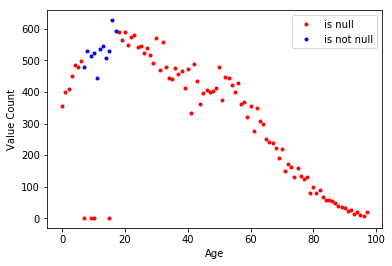

In [11]:
plt.plot(df[df.rez_esc.isnull()].age.value_counts(), 'r.', label='is null')
plt.plot(df[~df.rez_esc.isnull()].age.value_counts(), 'b.', label='is not null')
plt.xlabel('Age')
plt.ylabel('Value Count')
plt.legend()
plt.show()

We can fix this by setting all null values to zero, we'll also add a boolean variable if the value was NULL

In [12]:
df['rez_esc_MISSING'] = df.rez_esc.isnull().astype('int64')
df.loc[df.rez_esc.isnull(), 'rez_esc'] = 0

There is another variable **v18q** which is a boolean which represents whether or not the household owns a tablet. The examples which had a negative answer to this question must not have been asked how many tablets they owned, giving us so many missing examples. We can replace the missing values with 0.

In [13]:
print(df.v18q1.isnull().sum())
print(df.v18q.value_counts())

25468
0    25468
1     7945
Name: v18q, dtype: int64


In [14]:
df.v18q1.fillna(0, inplace=True)

An obvious explanation for missing values in monthly rent payments would behouseholds that do not pay rent. The answer to this lies in three other variables which describe the housing situation of the household **tipovivi**(=1 if own and fully paid house), **tipovivi4**(=1 if precarious), **tipovivi5**(=1 other (assigned, borrowed). Below we can see that these variables explain the missing values.

In [15]:
print(df.v2a1.isnull().sum()) # 24263

print(df.tipovivi1.sum()) # 20844 owns
print(df.tipovivi4.sum()) #   597 precarious
print(df.tipovivi5.sum()) #  2822 other
#                           -----
#                           24263 don't rent

# no rent = owns + precarious + other
df['v2a1_MISSING'] = df.v2a1.isnull().astype('int64')
df.loc[df.v2a1.isnull(), 'v2a1'] = 0

24263
20844
597
2822


In [ ]:
df.fillna(df.meaneduc.mean(), inplace=True) # simple mean imputation

## Decode one hot encodings

One hot encodings are awkward to visualise, and since we likely use a tree based ensemble model can be counter productive. Which columns are one hot encodings were discerned by looking at the descriptions on Kaggle.

In [16]:
# helper function
def decode_onehot(df, keyword, col_name, mappings=None):
    cols = [col for col in df.columns if col.startswith(keyword)]
    df[col_name] = pd.get_dummies(df[cols]).idxmax(1)
    if mappings is not None:
        df.replace(mappings, inplace=True)
    df.drop(cols, axis=1, inplace=True)

In [17]:
# maybe add mappings
decode_tars = [('pared', 'building_mat'),
                ('piso', 'floor_mat'),
                ('techo', 'roof_mat'),
                ('abasta', 'water_supply'),
                (('public', 'planpri', 'noelec', 'coopele'), 'elec_supply'),
                ('sanitario', 'sanit_supply'),
                ('energcocinar', 'cook_energy'),
                ('elimbasu', 'rubbish_disposal'),
                ('epared', 'wall_quality'),
                ('etecho', 'roof_quality'),
                ('eviv', 'floor_quality'),
                (('male', 'female'), 'gender'),
                ('estadocivil', 'relationship_status'),
                ('parentesco', 'family_role'),
                ('instlevel', 'edu_level'),
                ('tipovivi', 'home_own_status'),
                ('lugar', 'region'),
                ('area', 'urban_rural')]

for tar_prefix, new_col_name in decode_tars:
    decode_onehot(df, tar_prefix, new_col_name)

Split the data back up and save for further work

In [18]:
cl_train = df[:train_len]
cl_test = df[train_len:]

cl_train.to_csv('data/cleaned_train.csv', index=False)
cl_test.to_csv('data/cleaned_test.csv', index=False)